# Analysis of Nea. ancestry

In [1]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../R/utils.R")

})

In [2]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [3]:
suppressMessages(
array_snps <- load_dataset("../clean_data/ice_age.tsv",
                           "../clean_data/sgdp.tsv",
                           "../clean_data/archaics.tsv",
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

# list of samples with different library prep
non_udg_samples <- c("") #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha)) %>%
    mutate(method="direct")

Warning message:
“Unknown variables: ``”

In [4]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

Warning message:
“Unknown variables: ``”

## Nea ancestry proportion in Africans

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [5]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.transitions.snp")

### Calculate the number of SNPs available for each sample on the 2.2M array

In [6]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  id = col_character(),
  sex = col_character(),
  label = col_character()
)


### Generate a table of SNPs to filter out (transitions)

In [7]:
read_fwf(SNP_FILE,
         fwf_widths(c(20, 6, 16, 16, 2, 2),
                    col_names=c("id", "chrom", "gen", "pos", "alt", "ref")),
         progress=FALSE) %>%
    keep_transitions %>%
    filter(chrom %in% 1:22) %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


In [8]:
dir.create("../admixtools")
setwd("../admixtools")

Warning message in dir.create("../admixtools"):
“'../admixtools' already exists”

<br><br><br><br><br><br><br><br>
# Introduction
## A Tale of <del>Two</del> $N$ Neanderthal estimates, $N \in \{2, ..., \infty\}$


### Neanderthal estimates calculated on the archaic admixture array
![](img/decline_admixture_array.png)

Calculated simply as a proportion of alleles in an individual X that match a Neanderthal allele on biallelic sites at which:

* high-coverage Altai and Vindija genomes are homozygous for one allele,
* YRI population from 1000 GP phase I has a high frequency of the second allele (> 95%).

### Neanderthal estimates based on ratios of f4 statistics
![](img/decline_f4_ice_age.png)

Calculated on a combination of arrays, collectively called the 2.2M sites array:

![](img/2.2Marray.png)

Affymetrix Human Origins Array contains 11 different sets of SNPs, each ascertained on the basis of being heterozygous in a single genome sequence from each of the 11 different populations.

<br><br><br><br><br><br><br><br>
# Calculations of Nea ancestry estimate

## Nea. ancestry proportions using David's f4 ratio

![](img/mailund_f4_tree.png)

* A - West and Central Africans
* B - Dinka
* C - new_Altai
* O - Chimp


![](img/ice_age_f4_description.png)

My first attempt at reproducing the Ice Age f4 ratio:

In [9]:
my_iceage_Altai <- qpF4ratio(X=samples$name, A="Yoruba", B="new_Altai", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [10]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Archaics=c("new_Altai", "new_Vindija")))

In [11]:
my_iceage_Nea <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                       prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

My estimate of Ice Age setup, but using Denisovan:

In [12]:
my_iceage_Den <- qpF4ratio(X=samples$name, A="Yoruba", B="Denisovan", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

# Our new f4 ratio estimate

More straightforward & should be measuring what we _really_ want to measure:

![](img/mailund_f4_tree.png)

* A - new_Altai
* B - Vindija
* C - African
* O - Chimp

My new f4 estimates:

In [18]:
mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

## Comparison of f4 using old vs new Altai processing

In [49]:
old_mbuti  <- qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)

In [107]:
old_vs_new <-
    inner_join(rename(mbuti, new=alpha), rename(old_mbuti, old=alpha), by="X") %>%
    filter(old > 0, new > 0) %>% inner_join(samples, by=c("X"="name")) %>% select(name=X, old, new, pop)

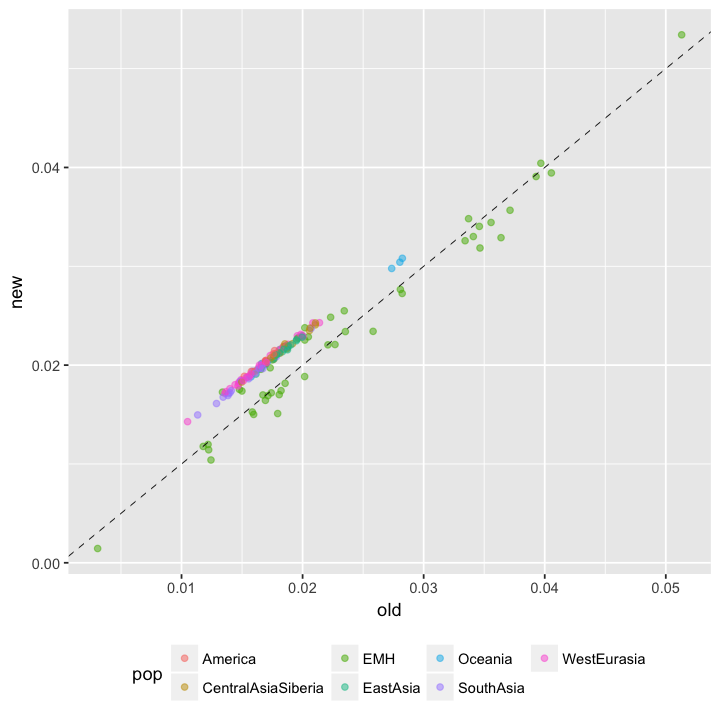

In [112]:
options(repr.plot.width=6, repr.plot.height=6)

old_vs_new %>% 
ggplot(aes(old, new, color=pop)) +
    geom_point(alpha=1/2) +
    geom_abline(linetype=2, size=0.25) +
    theme(legend.position="bottom")

### Merge all f4 results:

In [80]:
results <- bind_rows(list(my_iceage_Nea,
                          my_iceage_Den,
                          mbuti,
                          yoruba,
                          dinka)) %>% mutate(name=X, method=setup)

In [81]:
head(results)

A,B,X,C,O,alpha,stderr,z,setup,name,method
West_and_Central_Africans,Archaics,UstIshim,Dinka,Chimp,0.045299,0.004760,9.517,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp,UstIshim,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp
West_and_Central_Africans,Archaics,Kostenki14,Dinka,Chimp,0.035904,0.004903,7.323,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp,Kostenki14,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp
West_and_Central_Africans,Archaics,GoyetQ116-1,Dinka,Chimp,0.031344,0.005316,5.897,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp,GoyetQ116-1,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp
West_and_Central_Africans,Archaics,Muierii2,Dinka,Chimp,0.052575,0.012238,4.296,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp,Muierii2,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp
West_and_Central_Africans,Archaics,Paglicci133,Dinka,Chimp,0.032329,0.011467,2.819,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp,Paglicci133,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp
West_and_Central_Africans,Archaics,Cioclovina1,Dinka,Chimp,0.044897,0.029658,1.514,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp,Cioclovina1,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp


In [82]:
table(results$method)


qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp 
                                                      158 
                  qpF4ratio__Yoruba_Denisovan_Dinka_Chimp 
                                                      158 
             qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp 
                                                      158 
             qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp 
                                                      158 
            qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp 
                                                      158 

# Plot Nea. estimates over time

So far we have been focusing on evaluating various scenarios of selection that could reproduce the decrease in Neanderthal ancestry that we reported in the Ice Age paper [@fu_genetic_2016]. As a reminder, this is the slope of Neanderthal ancestry form the paper that we are trying to fit:

In [83]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

# combine tables with both estimates into a single table for comparison and merge
# them with counts of SNPs per sample on both admixture array and 2.2M sites arrays
all_nea_estimates <- inner_join(samples, bind_rows(mutate(inner_join(direct_nea, snp_counts_direct), z = Inf),
                                               inner_join(results, snp_counts_f4))) %>%
    select(name, age, pop, alpha, method, snp_count, z)

Joining, by = "name"
Joining, by = "name"
Joining, by = "name"


In [84]:
nea_estimates <- all_nea_estimates %>% 
    filter(pop %in% c("EMH", "WestEurasia"),
                      !name %in% c("BedouinB", "Druze", "Iranian", "Iraqi_Jew",
                                   "Jordanian", "Palestinian", "Samaritan", "Turkish", "Yemenite_Jew"),
                      !name %in% non_udg_samples)

In [85]:
filter(nea_estimates, name == "UstIshim")

name,age,pop,alpha,method,snp_count,z
UstIshim,45020,EMH,0.02781425,direct,157653,Inf
UstIshim,45020,EMH,0.04529900,qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp,1637960,9.517
UstIshim,45020,EMH,0.03971000,qpF4ratio__Yoruba_Denisovan_Dinka_Chimp,1637960,8.135
UstIshim,45020,EMH,0.02286200,qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp,1637960,5.775
UstIshim,45020,EMH,0.02670900,qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp,1637960,6.854
UstIshim,45020,EMH,0.02532600,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,1637960,6.681


In [86]:
plot_nea_vs_time <- function(m, age_cutoff=-Inf, ylim=c(0, 0.05)) {
    filter(nea_estimates,
           method == m,
           age > age_cutoff) %>% {(
    ggplot(., aes(age, alpha)) +
        geom_point(aes(size=snp_count, color=abs(z) > 3), alpha=3/4) +
        geom_smooth(aes(weight=snp_count), data=filter(., abs(z) > 3), method="lm", linetype=2, fullrange=TRUE, size=0.5) +
        xlim(47000, 0) + ylim(ylim[1], ylim[2]) +
        ggtitle(paste0("analysis setup: ", m))
    )}
}

run_lm <- function(m, zscore=0, snp_cutoff=0, age_cutoff=-Inf) {
    filter(nea_estimates,
           method == m,
           snp_count >= snp_cutoff,
           age >= age_cutoff,
           is.na(z) | abs(z) >= zscore) %>%
    { lm(.[["age"]] ~ .[["alpha"]]) } %>% 
    summary
}

## Results from the Ice Age paper

In [87]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]])

Residuals:
   Min     1Q Median     3Q    Max 
-10304  -6027  -4071   3130  38920 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -54546      10008  -5.450 2.03e-06 ***
.[["alpha"]]  3177861     485868   6.541 4.91e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9979 on 45 degrees of freedom
Multiple R-squared:  0.4874,	Adjusted R-squared:  0.476 
F-statistic: 42.78 on 1 and 45 DF,  p-value: 4.906e-08


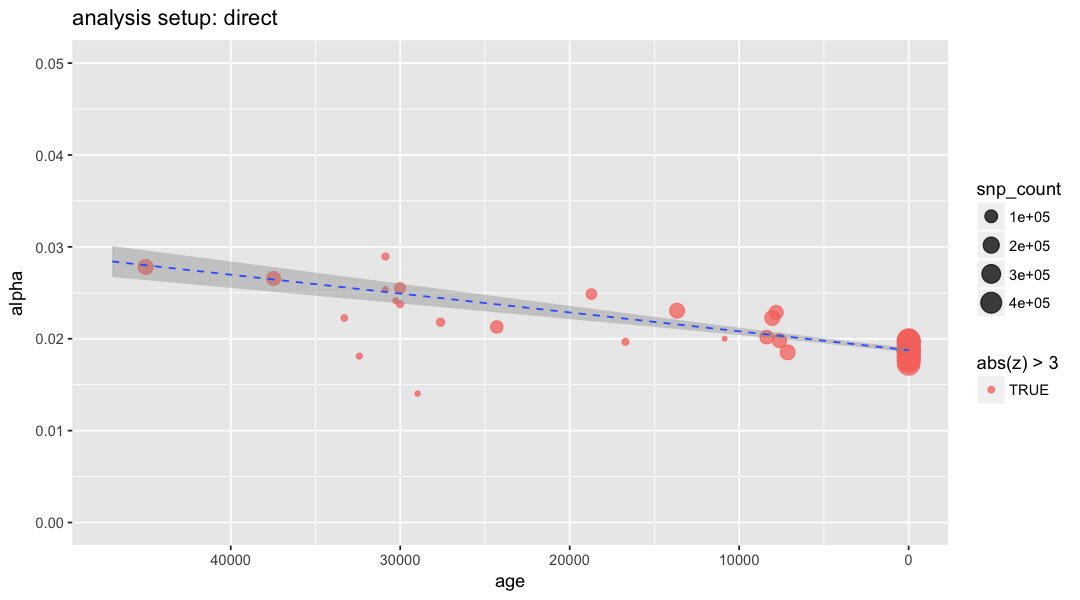

In [88]:
plot_nea_vs_time("direct")
run_lm("direct")

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 9 rows containing missing values (geom_point).”


Call:
lm(formula = .[["age"]] ~ .[["alpha"]])

Residuals:
   Min     1Q Median     3Q    Max 
-28970  -8731  -3950   9506  24931 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)      5242       2110   2.485   0.0154 *  
.[["alpha"]]   327769      68908   4.757 1.02e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11390 on 70 degrees of freedom
Multiple R-squared:  0.2443,	Adjusted R-squared:  0.2335 
F-statistic: 22.63 on 1 and 70 DF,  p-value: 1.023e-05


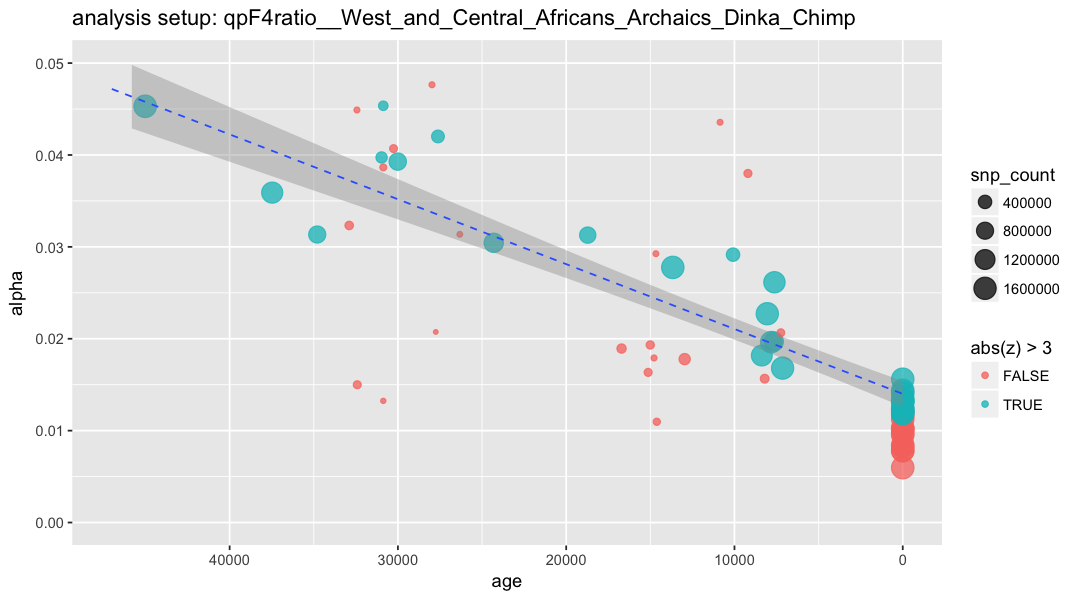

In [89]:
plot_nea_vs_time("qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp")
run_lm("qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp")

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 6 rows containing missing values (geom_point).”

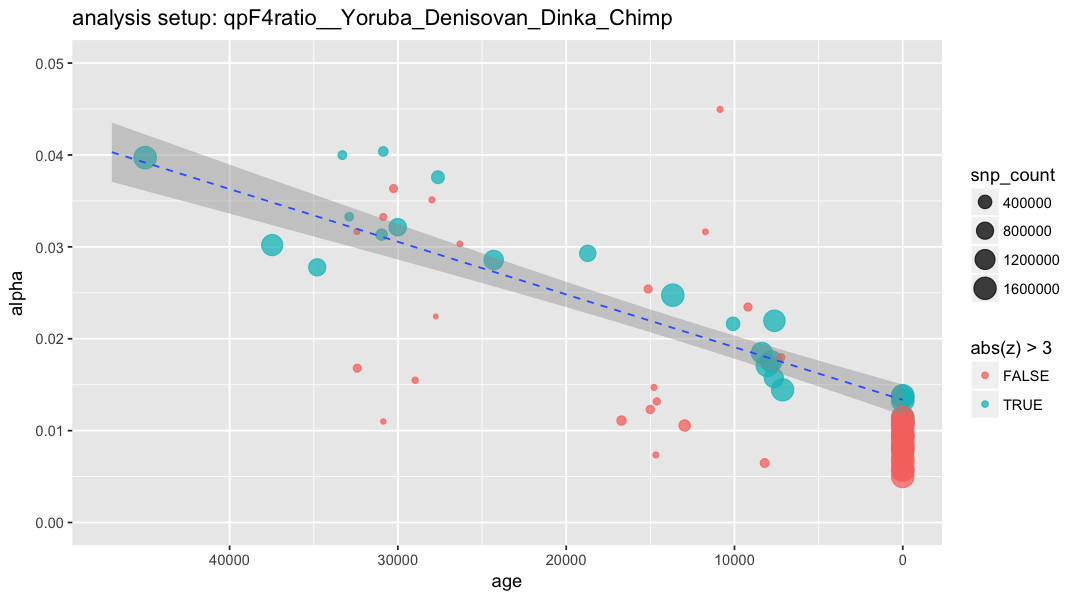

In [91]:
plot_nea_vs_time("qpF4ratio__Yoruba_Denisovan_Dinka_Chimp")

# New f4 results

In [93]:
table(results$method)


qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp 
                                                      158 
                  qpF4ratio__Yoruba_Denisovan_Dinka_Chimp 
                                                      158 
             qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp 
                                                      158 
             qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp 
                                                      158 
            qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp 
                                                      158 

In [87]:
options(repr.plot.width=9, repr.plot.height=5)

Warning message:
“Removed 5 rows containing missing values (geom_point).”

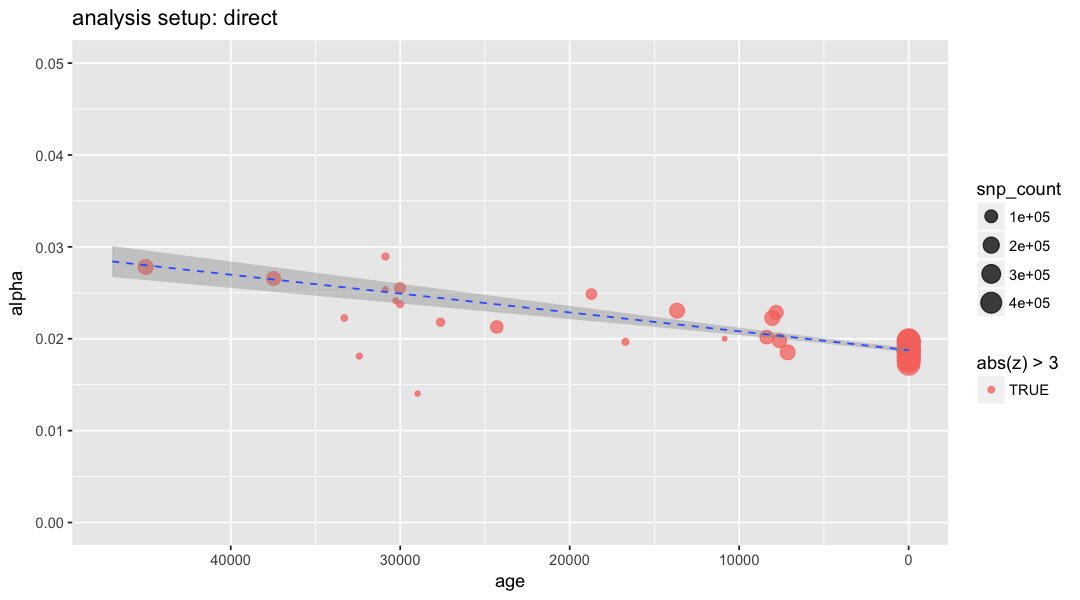

Warning message:
“Removed 5 rows containing missing values (geom_point).”

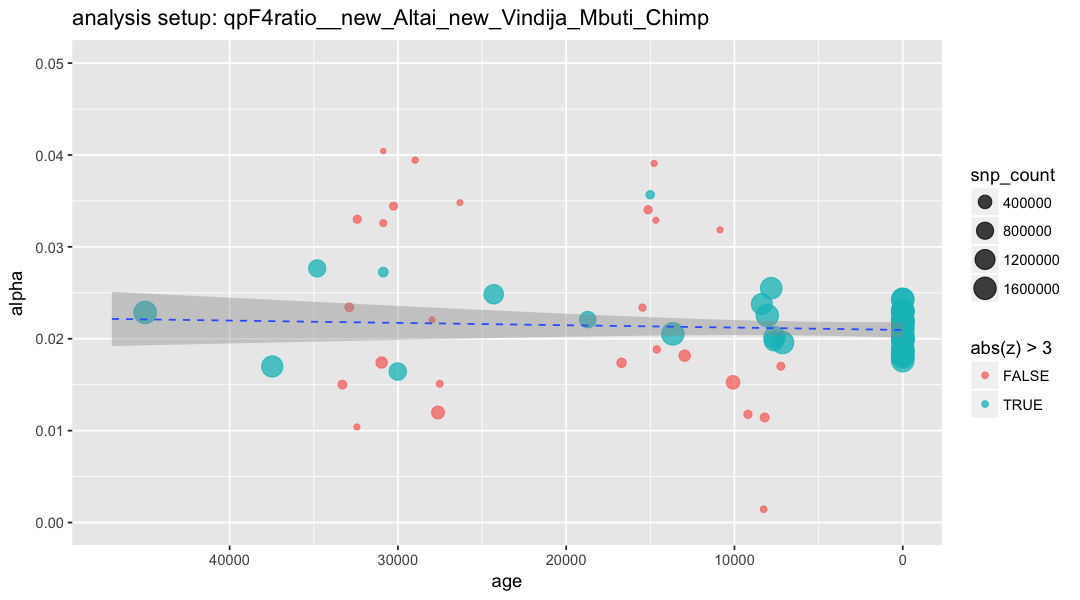

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

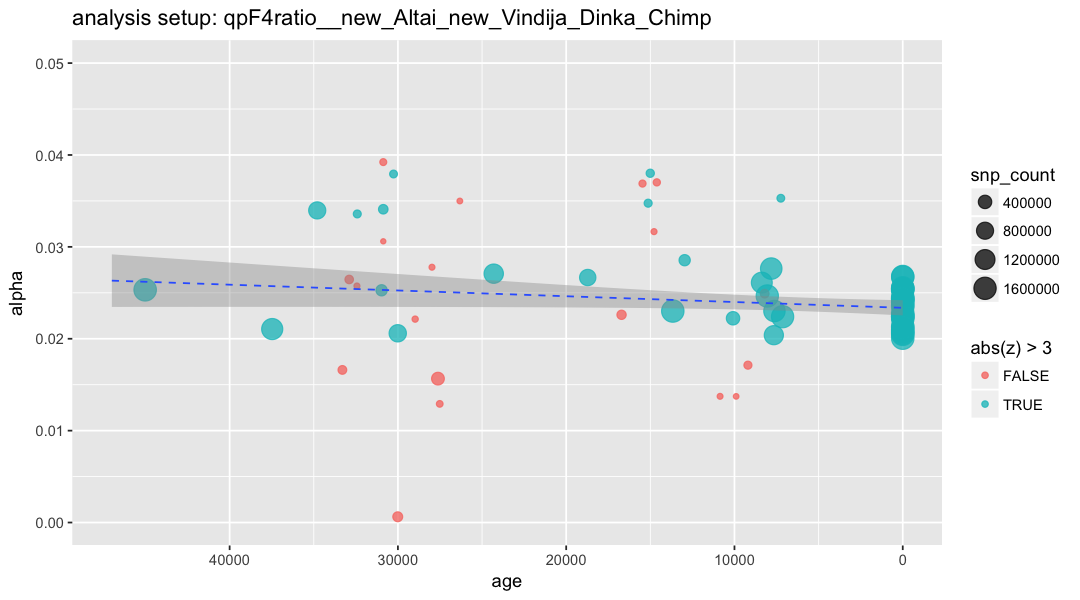

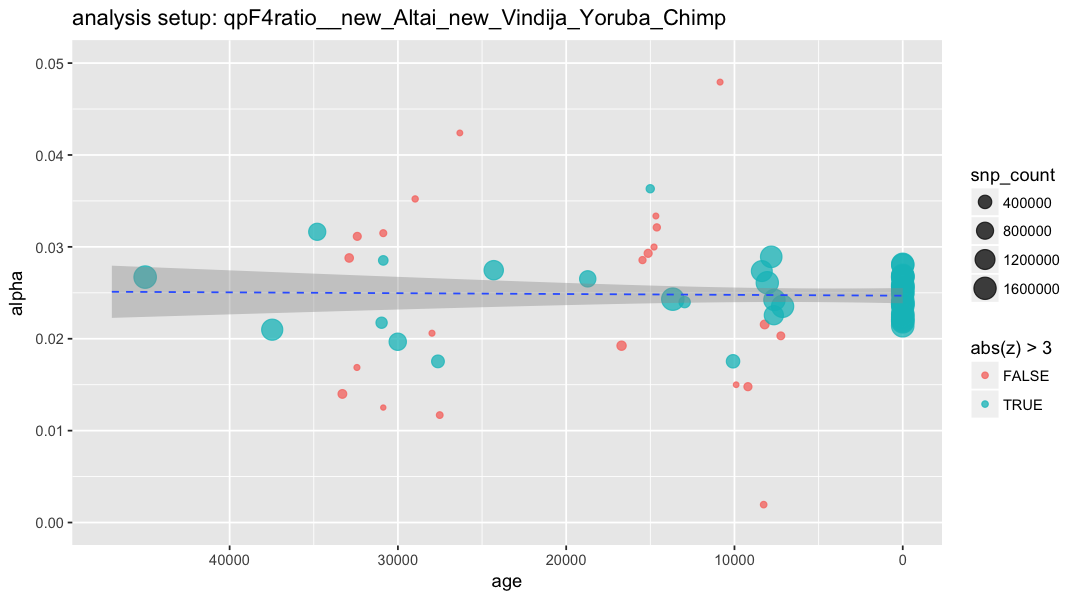

In [101]:
plot_nea_vs_time("direct")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")

In [102]:
save(all_nea_estimates, file="../RData/nea_estimates.RData")

<br><br><br><br><br><br><br><br><br><br>
# Comparisons of admixture array vs f4 Nea. estimates

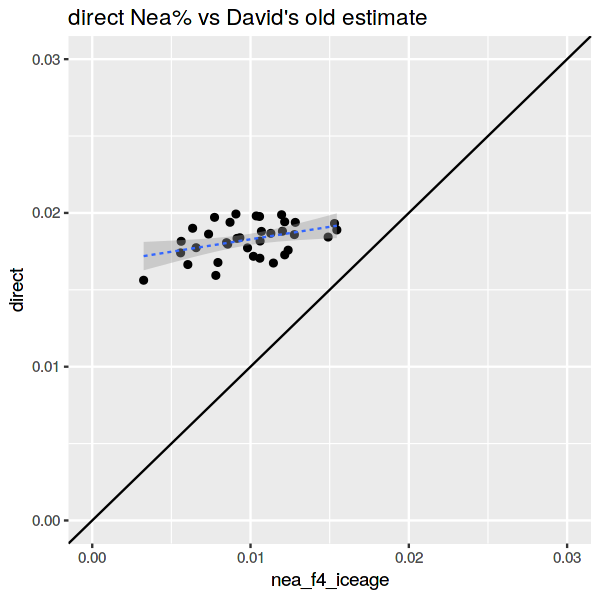

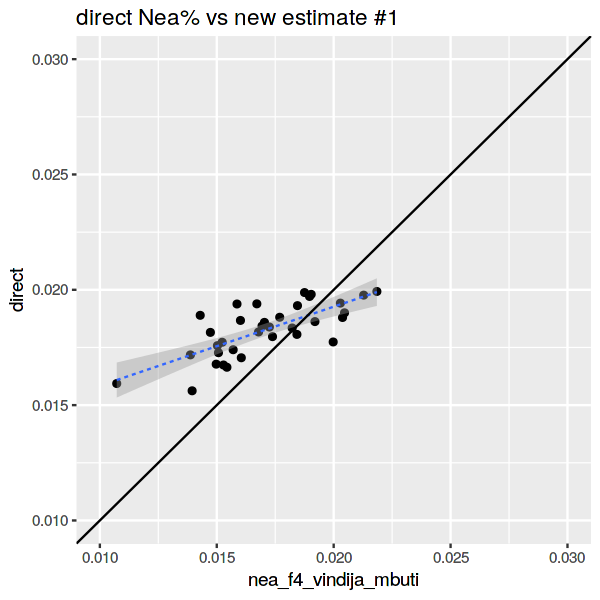

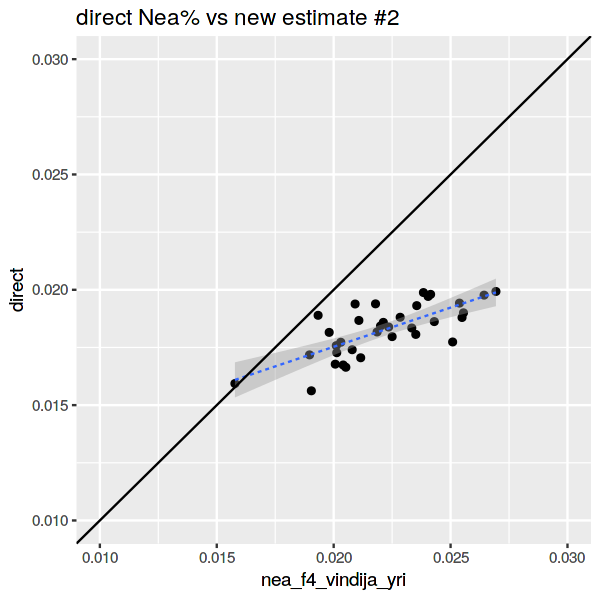

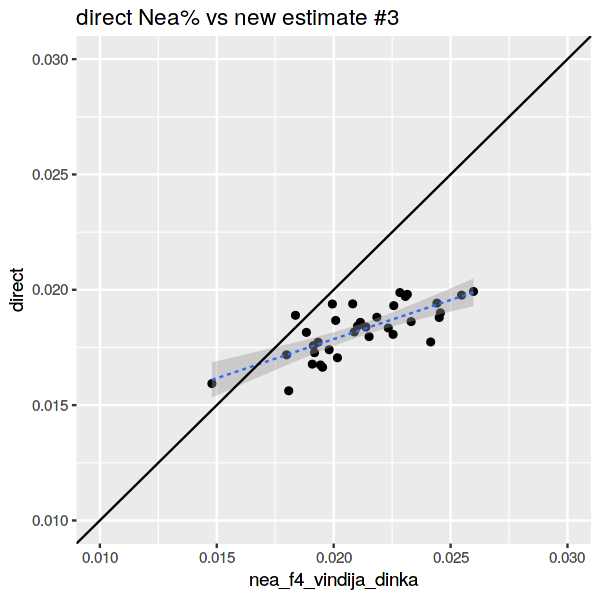

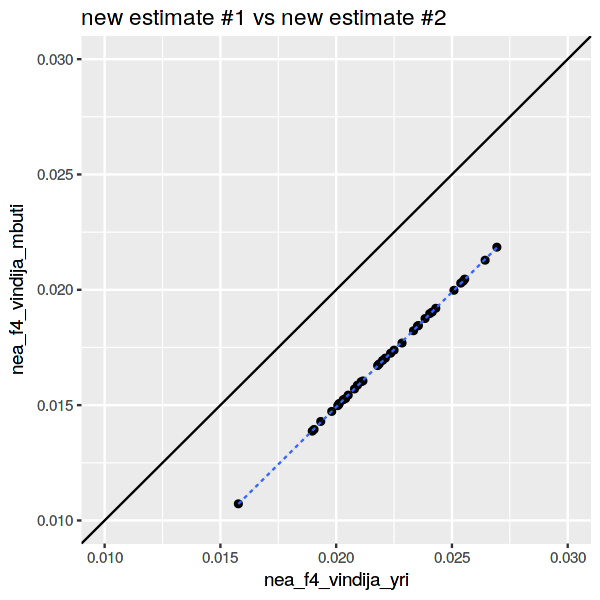

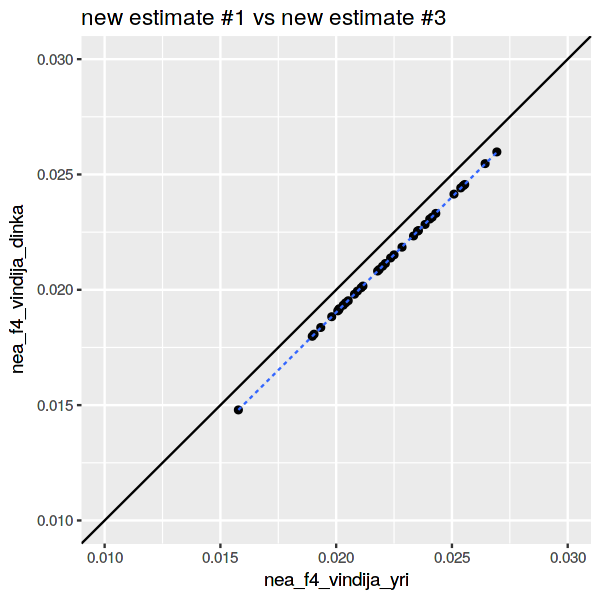

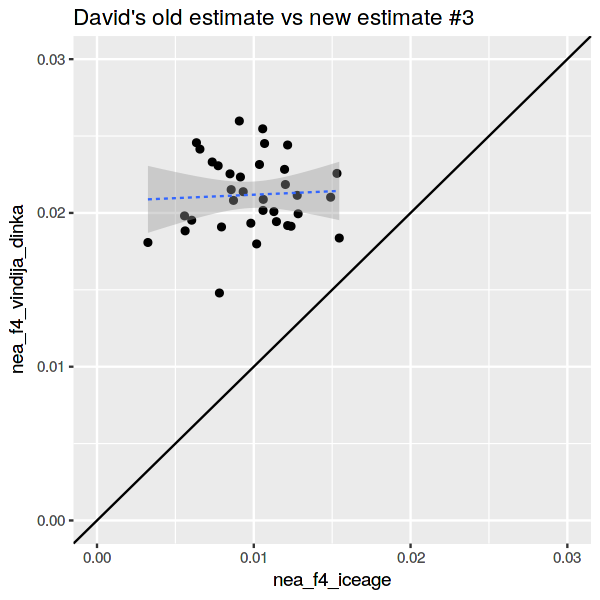

In [23]:
# comparison of f4 vs direct Nea. estimates

options(repr.plot.width=5, repr.plot.height=5)


nea_wide <- spread(mutate(nea_estimates, snp_count=NA), method, alpha) %>% filter(pop == "WestEurasia")

ggplot(nea_wide, aes(nea_f4_iceage, direct)) +
    geom_point() +
    geom_smooth(method="lm", linetype=2, size=0.5) +
    geom_abline(slope=1) +
    ggtitle("direct Nea% vs David's old estimate") + coord_cartesian(y=c(0.0, 0.03), x=c(0.0, 0.03))

ggplot(nea_wide, aes(nea_f4_vindija_mbuti, direct)) +
    geom_point() +
    geom_smooth(method="lm", linetype=2, size=0.5) +
    geom_abline(slope=1) +
    ggtitle("direct Nea% vs new estimate #1") + coord_cartesian(y=c(0.01, 0.03), x=c(0.01, 0.03))

ggplot(nea_wide, aes(nea_f4_vindija_yri, direct)) +
    geom_point() +
    geom_smooth(method="lm", linetype=2, size=0.5) +
    geom_abline(slope=1) +
    ggtitle("direct Nea% vs new estimate #2") + coord_cartesian(y=c(0.01, 0.03), x=c(0.01, 0.03))

ggplot(nea_wide, aes(nea_f4_vindija_dinka, direct)) +
    geom_point() +
    geom_smooth(method="lm", linetype=2, size=0.5) +
    geom_abline(slope=1) +
    ggtitle("direct Nea% vs new estimate #3") + coord_cartesian(y=c(0.01, 0.03), x=c(0.01, 0.03))

ggplot(nea_wide, aes(nea_f4_vindija_yri, nea_f4_vindija_mbuti)) +
    geom_point() +
    geom_smooth(method="lm", linetype=2, size=0.5) +
    geom_abline(slope=1) +
    ggtitle("new estimate #1 vs new estimate #2") + coord_cartesian(y=c(0.01, 0.03), x=c(0.01, 0.03))

ggplot(nea_wide, aes(nea_f4_vindija_yri, nea_f4_vindija_dinka)) +
    geom_point() +
    geom_smooth(method="lm", linetype=2, size=0.5) +
    geom_abline(slope=1) +
    ggtitle("new estimate #1 vs new estimate #3") + coord_cartesian(y=c(0.01, 0.03), x=c(0.01, 0.03))

ggplot(nea_wide, aes(nea_f4_iceage, nea_f4_vindija_dinka)) +
    geom_point() +
    geom_smooth(method="lm", linetype=2, size=0.5) +
    geom_abline(slope=1) +
    ggtitle("David's old estimate vs new estimate #3") + coord_cartesian(y=c(0.0, 0.03), x=c(0.0, 0.03))